In [4]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [5]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [6]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

1.ModernCNet

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0020,train acc 0.797176,val acc 0.812
epoch2,loss0.0018,train acc 0.841826,val acc 0.853
epoch3,loss0.0017,train acc 0.860682,val acc 0.869
epoch4,loss0.0017,train acc 0.870066,val acc 0.876
epoch5,loss0.0017,train acc 0.876880,val acc 0.887
epoch6,loss0.0017,train acc 0.884641,val acc 0.892
epoch7,loss0.0016,train acc 0.889458,val acc 0.897
epoch8,loss0.0016,train acc 0.896338,val acc 0.905
epoch9,loss0.0016,train acc 0.900765,val acc 0.911
epoch10,loss0.0016,train acc 0.907462,val acc 0.917
epoch11,loss0.0016,train acc 0.910479,val acc 0.919
epoch12,loss0.0016,train acc 0.911368,val acc 0.913
epoch13,loss0.0015,train acc 0.916001,val acc 0.922
epoch14,loss0.0015,train acc 0.915715,val acc 0.927
epoch15,loss0.0015,train acc 0.920377,val acc 0.913
epoch16,loss0.0015,train acc 0.921912,val acc 0.927
epoch17,loss0.0015,train acc 0.923938,val acc 0.918
epoch18,loss0.0015,train acc 0.923857,val acc 0.928
epoch19,loss0.0015,train acc 0.922242,val acc 0.928
epoch20,loss0.0015,tr

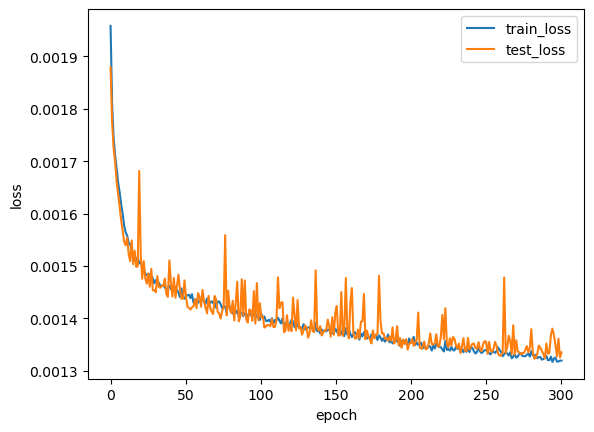

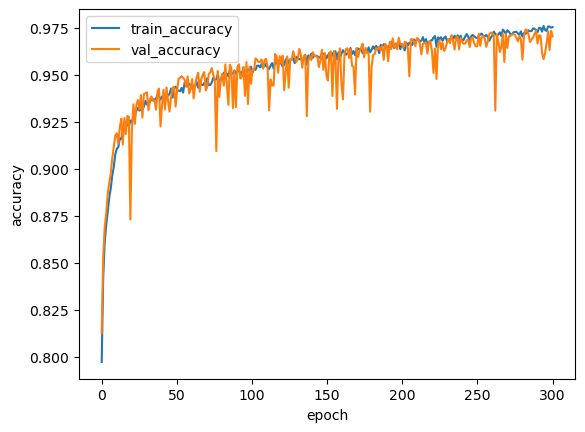

Accuracy on test set : 0.975
test precision: 0.9734000536606775  test recall: 0.9670747231774767  test f1_score: 0.9701016007399945


In [7]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

2.ModernCnet - res less

epoch1,loss0.0020,train acc 0.797514,val acc 0.811
epoch2,loss0.0018,train acc 0.836730,val acc 0.839
epoch3,loss0.0018,train acc 0.854441,val acc 0.866
epoch4,loss0.0017,train acc 0.863810,val acc 0.871
epoch5,loss0.0017,train acc 0.870095,val acc 0.879
epoch6,loss0.0017,train acc 0.875602,val acc 0.877
epoch7,loss0.0017,train acc 0.880228,val acc 0.885
epoch8,loss0.0017,train acc 0.886241,val acc 0.889
epoch9,loss0.0016,train acc 0.889663,val acc 0.893
epoch10,loss0.0016,train acc 0.892806,val acc 0.898
epoch11,loss0.0016,train acc 0.894384,val acc 0.892
epoch12,loss0.0016,train acc 0.898070,val acc 0.897
epoch13,loss0.0016,train acc 0.899370,val acc 0.893
epoch14,loss0.0016,train acc 0.903093,val acc 0.899
epoch15,loss0.0016,train acc 0.903225,val acc 0.902
epoch16,loss0.0016,train acc 0.903093,val acc 0.910
epoch17,loss0.0016,train acc 0.906353,val acc 0.912
epoch18,loss0.0016,train acc 0.908489,val acc 0.882
epoch19,loss0.0016,train acc 0.909694,val acc 0.909
epoch20,loss0.0016,tr

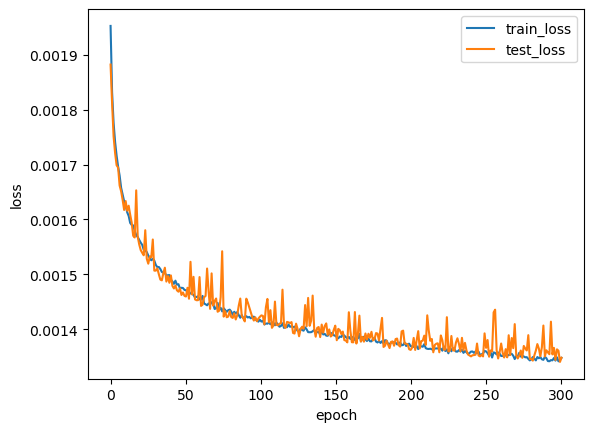

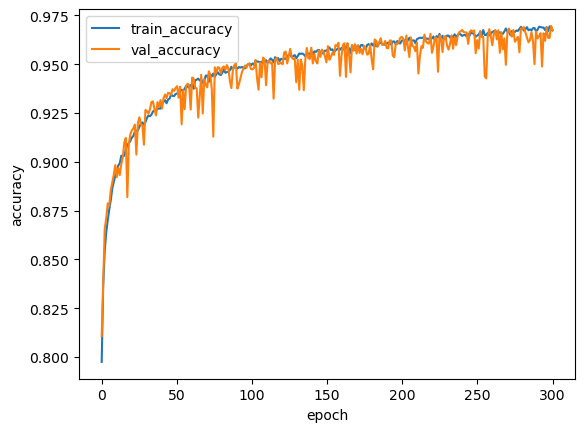

Accuracy on test set : 0.970
test precision: 0.9723080543676297  test recall: 0.9549623001188222  test f1_score: 0.9633716700637558


In [8]:
class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm = nn.LayerNorm(variable_dim*channel_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        residual = x
        x = rearrange(x, 'b v c s -> b (v c) s')
        y = self.conv_s(x)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        z = self.ffn_c(y)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        out = self.ffn_v(z)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        out = out + residual # b v c s
        out = rearrange(out, 'b v c s -> b (v c) s')
        out = out.permute(0,2,1)
        out = self.norm(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (v c) s -> b v c s', v=v)
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_res_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_res_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

3.ModernCNet -BN

In [ ]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_2 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_3 = nn.BatchNorm1d(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = self.norm_1(y + residual)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = self.norm_2(z + residual)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = self.norm_3(out + residual)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out



def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_BN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_BN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

4.ModernCNet -median kernel

In [ ]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=1),
        nn.Conv1d(in_channels=channel_dim,out_channels=channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=1)
        )

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim),
        nn.Conv1d(in_channels=variable_dim*channel_dim,out_channels=variable_dim*channel_dim,kernel_size=seq_len//2,padding='same',stride=1,groups=variable_dim*channel_dim)
        )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_MK_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_MK_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

5.ModernCnet - small kernel

In [ ]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=1),
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=1),
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=1),
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=1),
        nn.Conv1d(in_channels=1, out_channels=channel_dim,kernel_size=seq_len//5,padding='same',stride=1,groups=1),
                                )
    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Sequential(
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
        nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,kernel_size=seq_len//10,padding='same',stride=1,groups=variable_dim*channel_dim),
                                    )


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_SK_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_SK_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)